# This notebook compare the SNPs between H3Africa and 1KG, also check the imputation accuracy

1. SNP AF looks similar in H3Africa and 1KG after remove some alleles either not present in 1KG, or multi-alleles in 1KG, or \<INS>/\<DEL> in 1kg

2. The imputed TR major allele frequency looks similar to those from WGS

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde
import scipy.stats

# 1. Filtering SNPs for imputation

## Load files

In [3]:
af_1kg_dir ="../../additional_files/AFR_AF_from_1kg/" 
af_1kg_df = pd.DataFrame()
for chrom in range(1,23):
    curr_file = f"{af_1kg_dir}chr{chrom}_allele_frequencies.txt"
    curr_df = pd.read_csv(curr_file,sep="\t",header=None,names=["CHROM","POS","REF","ALT","AF"])
    af_1kg_df = pd.concat([curr_df, af_1kg_df],ignore_index=True)

In [4]:
print(f"1KG have {len(af_1kg_df):,} SNPs.")

1KG have 81,271,745 SNPs.


In [5]:
# H3Africa are all bi-alleles SNPs
h3afr_dir ="../../results/converted_vcf/"
h3afr_df = pd.DataFrame()
for chrom in range(1,23):
    curr_file = f"{h3afr_dir}chr{chrom}_allele_frequencies.txt"
    curr_df = pd.read_csv(curr_file,sep="\t",header=None,names=["CHROM","POS","REF","ALT","AF"])
    h3afr_df = pd.concat([curr_df, h3afr_df],ignore_index=True)
print(f"H3Africa have {len(h3afr_df):,} SNPs.")

H3Africa have 1,733,001 SNPs.


In [6]:
## add extra filter of F_MISSING
h3afr_dir ="../../results/converted_vcf/"
missing_df = pd.DataFrame()
for chrom in range(1,23):
    curr_file = f"{h3afr_dir}chr{chrom}_F_MISSING.vmiss"
    curr_df = pd.read_csv(curr_file,sep="\t", usecols=["#CHROM","POS","F_MISS"])
    missing_df = pd.concat([curr_df, missing_df],ignore_index=True)
missing_df.rename(columns={"#CHROM":"CHROM"},inplace=True)

## Filter H3Africa SNPs

In [7]:
h3afr_df_merged = h3afr_df.merge(af_1kg_df,on=["CHROM","POS"],suffixes=["_h3_AFR","_1kg_AFR"], how="left")

In [8]:
snp_notIn_1kg = h3afr_df_merged.AF_1kg_AFR.isnull()
snp_notBiIn_1kg = h3afr_df_merged[~snp_notIn_1kg].AF_1kg_AFR.str.contains(",")

In [9]:
merged_filter_notIn1kg = h3afr_df_merged[~snp_notIn_1kg].copy()
merged_filter_notIn1kg_noBio = merged_filter_notIn1kg[~snp_notBiIn_1kg].copy()
mismatched_alleles = (merged_filter_notIn1kg_noBio.REF_h3_AFR != merged_filter_notIn1kg_noBio.REF_1kg_AFR) | (merged_filter_notIn1kg_noBio.ALT_h3_AFR != merged_filter_notIn1kg_noBio.ALT_1kg_AFR)
merged_filter_final = merged_filter_notIn1kg_noBio[~mismatched_alleles].copy()

merged_filter_final["AF_1kg_AFR"]=merged_filter_final.AF_1kg_AFR.astype(float)
merged_filter_final["AF_h3_AFR"] = merged_filter_final["AF_h3_AFR"].apply(lambda x: round(x,4))
merged_filter_final.reset_index(inplace=True,drop=True)
merged_filter_final.drop(columns=["REF_1kg_AFR","ALT_1kg_AFR"],inplace=True)
merged_filter_final.rename(columns={"REF_h3_AFR":"REF","ALT_h3_AFR":"ALT"}, inplace=True)

In [10]:
# more number in the h3afr_df_merged after merged may due to none bi-alleles SNPs in 1kg
print(f"There are {len(h3afr_df_merged):,} SNPs after merged: \
\n\t{sum(snp_notIn_1kg):,} SNPs are not exist in 1KG;\
\n\t{sum(snp_notBiIn_1kg):,} SNPs are not bi-alleles in 1KG;\
\n\t{sum(mismatched_alleles):,} SNPs have different REF or ALT alleles in 1KG, most of which are <INS> or <DEL>).")

There are 1,733,374 SNPs after merged: 
	19,818 SNPs are not exist in 1KG;
	11,252 SNPs are not bi-alleles in 1KG;
	3,823 SNPs have different REF or ALT alleles in 1KG, most of which are <INS> or <DEL>).


## More filtering for quality check

In [11]:
ambiguous_alleles = ((merged_filter_final.REF=="T") & (merged_filter_final.ALT=="A")) | ((merged_filter_final.REF=="C") & (merged_filter_final.ALT=="AG"))
merged_filter_final = merged_filter_final.merge(missing_df,on=["CHROM","POS"])

In [12]:
def getMaf(AF):
    REF = 1 - AF
    return min([AF, REF])

merged_filter_final["MAF_h3_AFR"] = merged_filter_final.AF_h3_AFR.apply(lambda x: getMaf(x))
merged_filter_final["MAF_1kg_AFR"] = merged_filter_final.AF_1kg_AFR.apply(lambda x: getMaf(x))

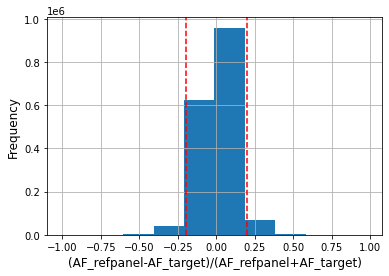

In [13]:
((merged_filter_final.AF_1kg_AFR-merged_filter_final.AF_h3_AFR)/(merged_filter_final.AF_1kg_AFR+merged_filter_final.AF_h3_AFR)).hist()
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("(AF_refpanel-AF_target)/(AF_refpanel+AF_target)",fontsize=12)
plt.axvline(x=0.2, color='red', linestyle="--")
plt.axvline(x=-0.2, color='red', linestyle="--")

In [14]:
maf_diff_filter = ((merged_filter_final.MAF_1kg_AFR-merged_filter_final.MAF_h3_AFR)/(merged_filter_final.MAF_1kg_AFR+merged_filter_final.MAF_h3_AFR)).abs()<0.2
print(f"{len(merged_filter_final)-maf_diff_filter.sum():,} SNPs are filtered by MAF diff < 0.2.")

118,046 SNPs are filtered by MAF diff < 0.2.


In [15]:
af_diff_filter = ((merged_filter_final.AF_1kg_AFR-merged_filter_final.AF_h3_AFR)/((merged_filter_final.AF_1kg_AFR+merged_filter_final.AF_h3_AFR))).abs()<0.2
print(f"{len(merged_filter_final)-af_diff_filter.sum():,} SNPs are filtered by AF diff < 0.2.")

109,868 SNPs are filtered by AF diff < 0.2.


## Visulize the concordance of SNP AF

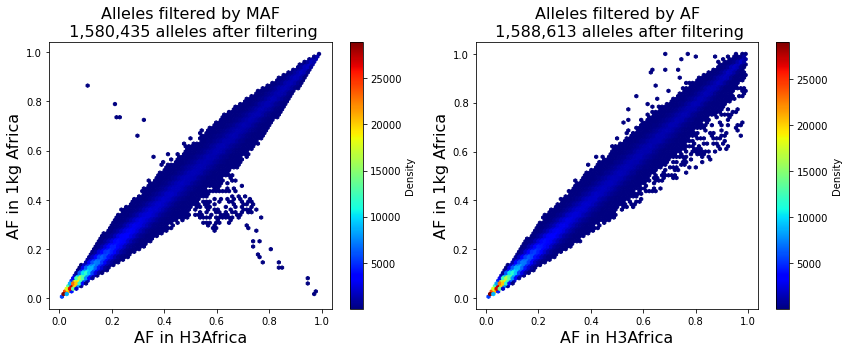

In [16]:
min_num = 1

fig, axs = plt.subplots(1,2,figsize=(12,5))
ax_list = axs.flatten()
x = merged_filter_final[maf_diff_filter ].AF_h3_AFR.tolist()
y = merged_filter_final[maf_diff_filter ].AF_1kg_AFR.tolist()
sc = ax_list[0].hexbin(x, y, gridsize=80, cmap="jet", mincnt=min_num)
cbar = plt.colorbar(sc, ax=ax_list[0])
cbar.set_label('Density')
ax_list[0].set_xlabel("AF in H3Africa", fontsize=16)
ax_list[0].set_ylabel("AF in 1kg Africa", fontsize=16)
ax_list[0].set_title(f"Alleles filtered by MAF\n {len(x):,} alleles after filtering", fontsize=16)
# fig.tight_layout()

min_num = 1
x = merged_filter_final[af_diff_filter].AF_h3_AFR.tolist()
y = merged_filter_final[af_diff_filter].AF_1kg_AFR.tolist()
sc = ax_list[1].hexbin(x, y, gridsize=80, cmap="jet", mincnt=min_num)
cbar = plt.colorbar(sc, ax=ax_list[1])
cbar.set_label('Density')
ax_list[1].set_xlabel("AF in H3Africa", fontsize=16)
ax_list[1].set_ylabel("AF in 1kg Africa", fontsize=16)
ax_list[1].set_title(f"Alleles filtered by AF\n {len(x):,} alleles after filtering", fontsize=16)
# plt.tight_layout()
fig.tight_layout()


### check ambiguous and unambiguous SNPs

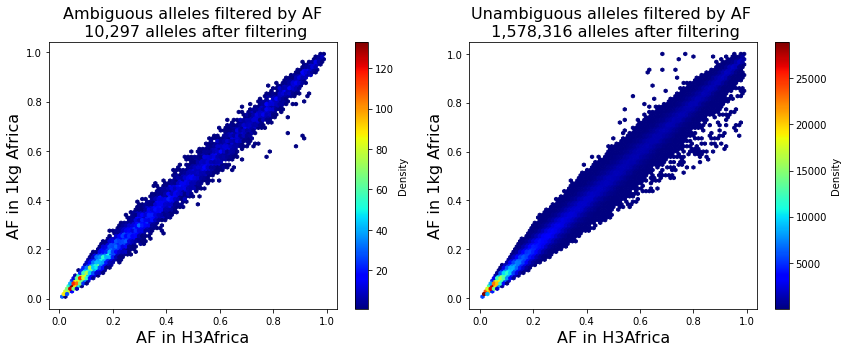

In [17]:
min_num = 1

fig, axs = plt.subplots(1,2,figsize=(12,5))
ax_list = axs.flatten()
x = merged_filter_final[af_diff_filter & ambiguous_alleles].AF_h3_AFR.tolist()
y = merged_filter_final[af_diff_filter & ambiguous_alleles].AF_1kg_AFR.tolist()
sc = ax_list[0].hexbin(x, y, gridsize=80, cmap="jet", mincnt=min_num)
cbar = plt.colorbar(sc, ax=ax_list[0])
cbar.set_label('Density')
ax_list[0].set_xlabel("AF in H3Africa", fontsize=16)
ax_list[0].set_ylabel("AF in 1kg Africa", fontsize=16)
ax_list[0].set_title(f"Ambiguous alleles filtered by AF\n {len(x):,} alleles after filtering", fontsize=16)
# fig.tight_layout()

min_num = 1
x = merged_filter_final[af_diff_filter & ~ambiguous_alleles].AF_h3_AFR.tolist()
y = merged_filter_final[af_diff_filter & ~ambiguous_alleles].AF_1kg_AFR.tolist()
sc = ax_list[1].hexbin(x, y, gridsize=80, cmap="jet", mincnt=min_num)
cbar = plt.colorbar(sc, ax=ax_list[1])
cbar.set_label('Density')
ax_list[1].set_xlabel("AF in H3Africa", fontsize=16)
ax_list[1].set_ylabel("AF in 1kg Africa", fontsize=16)
ax_list[1].set_title(f"Unambiguous alleles filtered by AF \n {len(x):,} alleles after filtering", fontsize=16)
# plt.tight_layout()
fig.tight_layout()


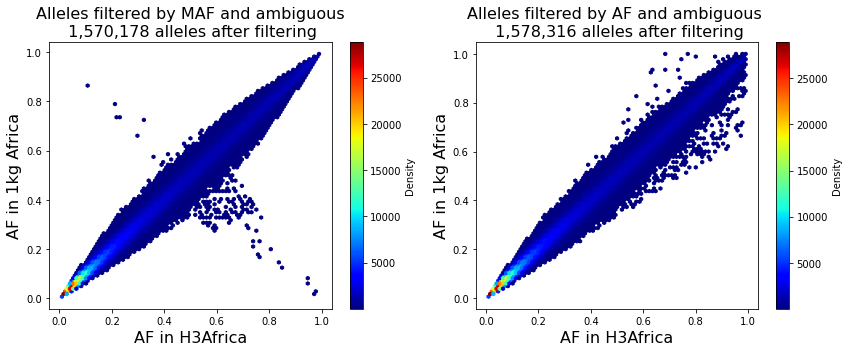

In [18]:
min_num = 1

fig, axs = plt.subplots(1,2,figsize=(12,5))
ax_list = axs.flatten()
x = merged_filter_final[maf_diff_filter & ~ambiguous_alleles].AF_h3_AFR.tolist()
y = merged_filter_final[maf_diff_filter & ~ambiguous_alleles].AF_1kg_AFR.tolist()
sc = ax_list[0].hexbin(x, y, gridsize=80, cmap="jet", mincnt=min_num)
cbar = plt.colorbar(sc, ax=ax_list[0])
cbar.set_label('Density')
ax_list[0].set_xlabel("AF in H3Africa", fontsize=16)
ax_list[0].set_ylabel("AF in 1kg Africa", fontsize=16)
ax_list[0].set_title(f"Alleles filtered by MAF and ambiguous\n {len(x):,} alleles after filtering", fontsize=16)
# fig.tight_layout()

min_num = 1
x = merged_filter_final[af_diff_filter & ~ambiguous_alleles].AF_h3_AFR.tolist()
y = merged_filter_final[af_diff_filter & ~ambiguous_alleles].AF_1kg_AFR.tolist()
sc = ax_list[1].hexbin(x, y, gridsize=80, cmap="jet", mincnt=min_num)
cbar = plt.colorbar(sc, ax=ax_list[1])
cbar.set_label('Density')
ax_list[1].set_xlabel("AF in H3Africa", fontsize=16)
ax_list[1].set_ylabel("AF in 1kg Africa", fontsize=16)
ax_list[1].set_title(f"Alleles filtered by AF and ambiguous \n {len(x):,} alleles after filtering", fontsize=16)
# plt.tight_layout()
fig.tight_layout()

### save SNPs need to be removed

In [32]:
 for i in range(1,23):
    #merged_filter_final[af_diff_filter][["CHROM","POS"]].sort_values(by=["CHROM","POS"]).to_csv("../../results/converted_vcf/SNPs_failed_QC.txt",sep="\t", index=False, header=None)
    merged_filter_final[af_diff_filter 
                        &(merged_filter_final.CHROM==i)
                       ][["CHROM","POS"]].sort_values(by=["CHROM","POS"]).to_csv(f"../../results/converted_vcf/SNPs_failed_QC/chr{i}.txt",sep="\t", index=False, header=None)

In [28]:
 merged_filter_final[af_diff_filter ][["CHROM","POS"]].sort_values(by=["CHROM","POS"]).reset_index().loc[range(66800,66810)]

,CHROM,POS
1566976,1,723918
1566977,1,728951
1566978,1,752721
1566979,1,760912
1566980,1,762320
...,...,...
23898,22,51184564
23899,22,51186228
23900,22,51188354
23901,22,51213613


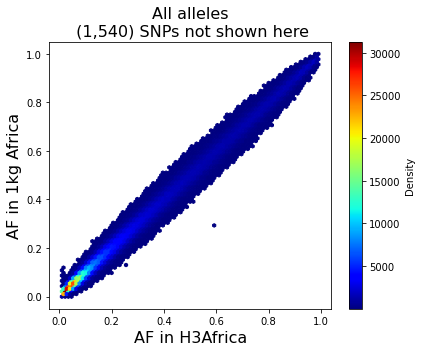

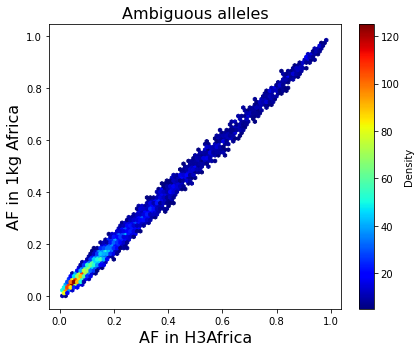

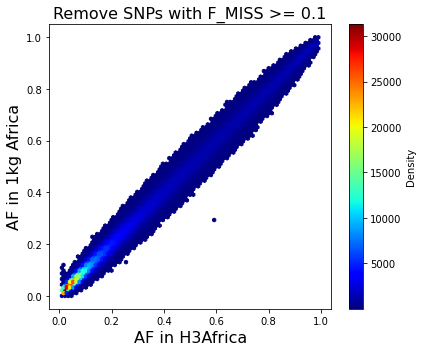

In [130]:
min_num = 5

fig, ax = plt.subplots(figsize=(6,5))
x = merged_filter_final.AF_hreset_index.tolist()
y = merged_filter_final.AF_1kg_AFR.tolist()
hb = plt.hexbin(x, y, gridsize=80, cmap="jet", mincnt=min_num)
filtered_allele_num = len(merged_filter_final)-int(hb.get_array().sum())
cbar = plt.colorbar()
cbar.set_label('Density')
plt.xlabel("AF in H3Africa", fontsize=16)
plt.ylabel("AF in 1kg Africa", fontsize=16)
plt.title(f"All alleles\n ({filtered_allele_num:,}) SNPs not shown here", fontsize=16)
plt.tight_layout()
plt.show()

# compare only ambiguous_alleles allele frequencies
fig, ax = plt.subplots(figsize=(6,5))
x = merged_filter_final[ambiguous_alleles].AF_h3_AFR.tolist()
y = merged_filter_final[ambiguous_alleles].AF_1kg_AFR.tolist()
plt.hexbin(x, y, gridsize=80, cmap="jet", mincnt=min_num)
cbar = plt.colorbar()
cbar.set_label('Density')
plt.xlabel("AF in H3Africa", fontsize=16)
plt.ylabel("AF in 1kg Africa",fontsize=16)
plt.title("Ambiguous alleles",fontsize=16)
plt.tight_layout()
plt.show()

# compare only ambiguous_alleles allele frequencies
fig, ax = plt.subplots(figsize=(6,5))
x = merged_filter_final[merged_filter_final.F_MISS<0.1].AF_h3_AFR.tolist()
y = merged_filter_final[merged_filter_final.F_MISS<0.1].AF_1kg_AFR.tolist()
plt.hexbin(x, y, gridsize=80, cmap="jet", mincnt=min_num)
cbar = plt.colorbar()
cbar.set_label('Density')
plt.xlabel("AF in H3Africa", fontsize=16)
plt.ylabel("AF in 1kg Africa",fontsize=16)
plt.title("Remove SNPs with F_MISS >= 0.1",fontsize=16)
plt.tight_layout()
plt.show()

# 2. Check imputed STR concordance

Compare the STRs called from AWIGEN WGS dataset and those imputed

* There are total 100 WGS samples, and 97 of those also have imputed STRs.

In [6]:
wgs_samples = pd.read_csv("/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/awigen_dataset/WGS_TR_call_from_Ibra/awigen_wgs_samples.txt",header=None, names=["WGS_samples"])
awigen_samples = pd.read_csv("/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/results/converted_lifted_vcf/chr21/chr21_sample_list.txt",sep="\t",header=None, names=["AWIGEN_samples"],usecols=[0])
print(f"{len(set(awigen_samples.AWIGEN_samples.tolist()) & set(wgs_samples.WGS_samples.tolist())):,} samples from the AWIGEN imputation also have WGS.")
shared_samples = awigen_samples.merge(wgs_samples,right_on=["WGS_samples"],left_on=["AWIGEN_samples"])[["WGS_samples"]]
shared_samples.to_csv("/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/awigen_dataset/WGS_TR_call_from_Ibra/awigen_wgs_shared_samples.txt",sep="\t",index=False,header=None)

97 samples from the AWIGEN imputation also have WGS.


In [7]:
real_call = pd.read_csv("/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/awigen_dataset/WGS_TR_call_from_Ibra/awigen_sorted.tab",sep="\t")
wgs_chr21 = real_call[real_call.chrom=="chr21"].copy().reset_index(drop=True)

In [8]:
imputed_100_chr21 = pd.read_csv("/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/results/imputed_TRs/chr21/chr21_imputed_and_annotated_TRs_100_samples.tab",sep="\t")
imputed_100_chr21.rename(columns={i:i.split("-")[0] for i in imputed_100_chr21.columns.tolist()}, inplace=True)

In [9]:
imputed_chr21 = pd.read_csv("/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/results/imputed_TRs/chr21/chr21_imputed_and_annotated_TRs.tab",sep="\t")

### Get a venndigram

### Compare Major allele frequency
The WGS EnsembleTR was called on 100 AWIGEN samples only, so the ALT alleles may not be the same.

1. Check if the Major allele frequencies are the same across the WGS and imputed dataset. 

In [3]:
def get_overlap(dict1, dict2):
    """
    compare two allele frequency dictionary from WGS and imputation, check the fraction of the alleles have identical frequencies
    """
    # Find the common key-value pairs
    common = {k: dict1[k] for k in dict1 if k in dict2 and dict1[k] == dict2[k]}
    # Determine the longest dictionary based on the number of key-value pairs
    longest_dict_length = max(len(dict1), len(dict2))
    # Calculate the fraction of overlap based on the longest dictionary
    overlap_fraction = len(common) / longest_dict_length
    return overlap_fraction

def getMajA(allele_list, imputed_list):
    """
    get the allele with max frequency for each STR, then compare its frequency in impuated and hard-called dataset
    """
    alleles = [a.split(":")[0] for a in allele_list]
    freqs = [round(float(a.split(":")[1]),2) for a in allele_list]
    wgs_maxf = max(freqs)
    major_a = alleles[freqs.index(wgs_maxf)]
    wgs_dict = dict(zip(alleles, freqs))
    
    impute_alleles = [a.split(":")[0] for a in imputed_list]
    impute_freqs = [round(float(a.split(":")[1]),2) for a in imputed_list]
    impute_dict = dict(zip(impute_alleles, impute_freqs)) 
    
    overlap_fraction = get_overlap(wgs_dict,impute_dict)
    try:
        impute_maxf = impute_freqs[impute_alleles.index(major_a)]
        return wgs_maxf, impute_maxf, overlap_fraction
    except:
        return wgs_maxf, None, overlap_fraction

In [10]:
merged_identical_sample_STRs = imputed_100_chr21.merge(wgs_chr21.drop_duplicates(subset=["chrom","start","end"]), 
                                                       on=["chrom","start","end","thresh"], 
                                                       suffixes=["_imputed","_wgs"])
merged_identical_sample_STRs[["wgs_major_fre","impute_major_fre","overlap_fraction"]]=merged_identical_sample_STRs.apply(lambda x: getMajA(x.afreq_imputed.split(","), x.afreq_wgs.split(",")), axis=1,result_type="expand")

In [11]:
merged_STRs = imputed_chr21.merge(wgs_chr21.drop_duplicates(subset=["chrom","start","end"]), 
                                  on=["chrom","start","end","thresh"], 
                                  suffixes=["_imputed","_wgs"])
merged_STRs[["wgs_major_fre","impute_major_fre","overlap_fraction"]]=merged_STRs.apply(lambda x: getMajA(x.afreq_imputed.split(","), x.afreq_wgs.split(",")), axis=1,result_type="expand")

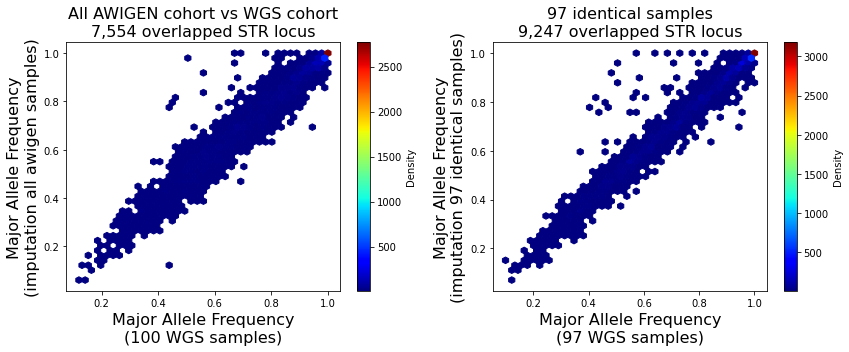

In [193]:
min_num = 1

fig, axs = plt.subplots(1,2,figsize=(12,5))
ax_list = axs.flatten()
plot_data = merged_STRs
x = plot_data.wgs_major_fre.tolist()
y = plot_data.impute_major_fre.tolist()
sc = ax_list[0].hexbin(x, y, gridsize=40, cmap="jet", mincnt=min_num)

cbar = plt.colorbar(sc, ax=ax_list[0])
cbar.set_label('Density')
ax_list[0].set_xlabel("Major Allele Frequency\n(100 WGS samples)", fontsize=16)
ax_list[0].set_ylabel(f"Major Allele Frequency\n(imputation all awigen samples)", fontsize=16)
ax_list[0].set_title(f"All AWIGEN cohort vs WGS cohort\n{len(merged_STRs):,} overlapped STR locus", fontsize=16)

plot_data = merged_identical_sample_STRs
x = plot_data.wgs_major_fre.tolist()
y = plot_data.impute_major_fre.tolist()
sc = ax_list[1].hexbin(x, y, gridsize=40, cmap="jet", mincnt=min_num)

cbar = plt.colorbar(sc, ax=ax_list[1])
cbar.set_label('Density')
ax_list[1].set_xlabel("Major Allele Frequency\n(97 WGS samples)", fontsize=16)
ax_list[1].set_ylabel(f"Major Allele Frequency\n(imputation 97 identical samples)", fontsize=16)
ax_list[1].set_title(f"97 identical samples\n{len(plot_data):,} overlapped STR locus", fontsize=16)
fig.tight_layout()

### compare TR concordance at sample level

In [13]:
def getAlleleLen(row):
    """
    """
    alleles = row.REF if row.ALT == "." else row.REF+","+row.ALT
    alleles_dict = {i:len(tr) for i, tr in enumerate(alleles.split(","))}
    return alleles_dict

def getSumLen(gt, len_dict):
    """
    this function apply to the pandas series, 
    use the len_dict to get the length
    """
    if "." in gt:
        return None
    else:
        if "/" in gt:
            gt_list = [int(i) for i in gt.split("/")]
        else:
            gt_list = [int(i) for i in gt.split("|")]
        if len(gt_list) == 2:
            return len_dict[gt_list[0]] + len_dict[gt_list[1]]
        else:
            return None
        
def getMeanLen(gt, len_dict):
    """
    this function apply to the pandas series, 
    use the len_dict to get the length
    """
    if "." in gt:
        return None
    else:
        if "/" in gt:
            gt_list = [int(i) for i in gt.split("/")]
        else:
            gt_list = [int(i) for i in gt.split("|")]
        if len(gt_list) == 2:
            return (len_dict[gt_list[0]] + len_dict[gt_list[1]])/2
        else:
            return None

In [14]:
wgs_df = pd.read_csv("/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/awigen_dataset/WGS_TR_call_from_Ibra/wgs_shared_TR_GTs.tab",sep="\t")
impute_df = pd.read_csv("/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/results/imputed_TRs/chr21/imputed_shared_TR_GTs.tab",sep="\t")
wgs_df.drop(columns='Unnamed: 103',inplace=True)
impute_df.drop(columns='Unnamed: 103',inplace=True)

In [16]:
from tqdm import tqdm

In [18]:
tqdm.pandas()

In [ ]:
# get list of TRs identified in both WGS and imputation 
shared_TRs = wgs_df[["CHROM","POS","END","REF"]].merge(impute_df[["CHROM","POS","END","REF"]], on=["CHROM","POS","END","REF"]).drop_duplicates()

sample_list = wgs_df.columns[6:].tolist()

start_list = []
end_list = []

called_sample_n = []

len_diff_list = []
identical_call_list = []
# in case of multiple TRs with the same START and END
tr_id_list = []
# some TRs have one alleles, those are expected to have high concordant
wgs_allele_n_list = []
impute_allele_n_list = []

pearson_r_list = []
pearson_p_list = []

for _, row in tqdm(shared_TRs.iterrows(),total=len(shared_TRs)):
    curr_pos = row.POS
    curr_end = row.END
    
    curr_wgs = wgs_df[(wgs_df.POS==curr_pos) & (wgs_df.POS==curr_pos)]
    curr_impute = impute_df[(impute_df.POS==curr_pos) & (impute_df.POS==curr_pos)]
    
    tr_id = 0
    for _, wgs_row in curr_wgs.iterrows():
        wgs_len_dict = getAlleleLen(wgs_row)
        wgs_gt_sum = np.array(wgs_row.loc[sample_list].map(lambda x: getSumLen(x, wgs_len_dict)).values)
        wgs_gt_mean = np.array(wgs_row.loc[sample_list].map(lambda x: getMeanLen(x, wgs_len_dict)).values)

        called_wgs_id = np.argwhere(~np.isnan(wgs_gt_sum)).flatten()
        for _, impute_row in curr_impute.iterrows():
            impute_len_dict = getAlleleLen(impute_row)
            impute_gt_sum = np.array(impute_row.loc[sample_list].map(lambda x: getSumLen(x, impute_len_dict)).values)
            impute_gt_mean = np.array(impute_row.loc[sample_list].map(lambda x: getMeanLen(x, impute_len_dict)).values)
            
            len_diff = (np.abs(impute_gt_mean[called_wgs_id] - wgs_gt_mean[called_wgs_id])).sum()
            identical_calls_num = (impute_gt_sum[called_wgs_id] == wgs_gt_sum[called_wgs_id]).sum()
            if identical_calls_num == called_wgs_id.size:
                r=1
                p=0
                pearson_r_list.append(r)
                pearson_p_list.append(p)
            else:
                r,p = scipy.stats.pearsonr(impute_gt_sum[called_wgs_id],wgs_gt_sum[called_wgs_id])
                pearson_r_list.append(round(r,2))
                pearson_p_list.append(p)

            start_list.append(curr_pos)
            end_list.append(curr_end)
            called_sample_n.append(called_wgs_id.size)
            len_diff_list.append(len_diff)
            identical_call_list.append(identical_calls_num)
            tr_id_list.append(tr_id)
            wgs_allele_n_list.append(len(wgs_len_dict))
            impute_allele_n_list.append(len(impute_len_dict))
            tr_id += 1
    

concord_df = pd.DataFrame({"START":start_list, 
                           "END":end_list, 
                           "sample_n":called_sample_n, 
                           "pearson_r":pearson_r_list,
                           "pearson_p":pearson_p_list,
                           "len_diff_sum":len_diff_list, 
                           "concordant_sample_n":identical_call_list, 
                           "wgs_alleles_num":wgs_allele_n_list, 
                           "impute_alleles_num":impute_allele_n_list})
# concord_df.to_csv("/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/awigen_dataset/WGS_TR_call_from_Ibra/concondant_check_summary.tab",sep="\t",index=False)
# # For duplicated TRs, choose those with max number of concordant samples
# concord_df_final = concord_df.loc[concord_df.groupby(["START","END"])["concordant_sample_n"].idxmax()].copy()
# concord_df_final["concordant_frac"] = (concord_df_final.concordant_sample_n/concord_df_final.sample_n).apply(lambda x: round(x, 2))

In [83]:
concord_df_final = concord_df.loc[concord_df.groupby(["START","END"])["concordant_sample_n"].idxmax()].copy()
concord_df_final["concordant_frac"] = (concord_df_final.concordant_sample_n/concord_df_final.sample_n).apply(lambda x: round(x, 2))

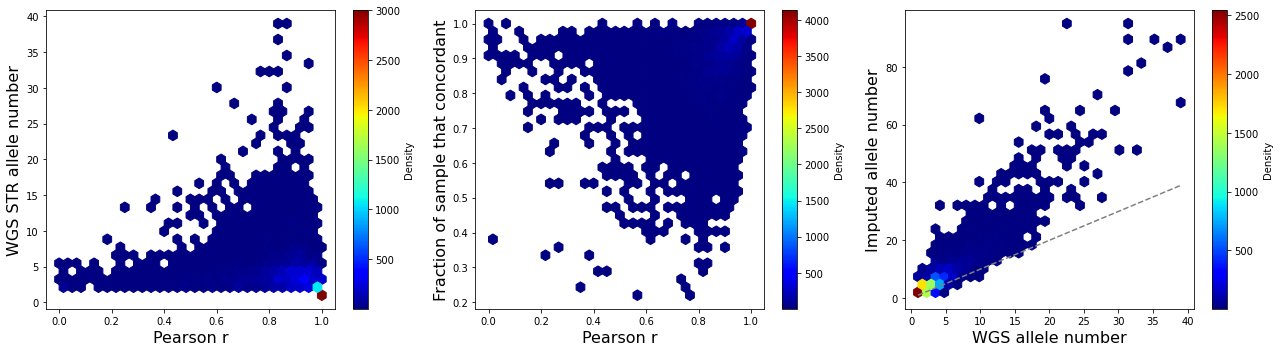

In [133]:
min_num = 1

fig, axs = plt.subplots(1,3,figsize=(18,5))
ax_list = axs.flatten()
x = concord_df_final.pearson_r.abs().tolist()
y = concord_df_final.wgs_alleles_num.tolist()
sc = ax_list[0].hexbin(x, y, gridsize=30, cmap="jet", mincnt=min_num)
cbar = plt.colorbar(sc, ax=ax_list[0])
cbar.set_label('Density')
ax_list[0].set_xlabel("Pearson r", fontsize=16)
ax_list[0].set_ylabel("WGS STR allele number", fontsize=16)

x = concord_df_final.pearson_r.abs().tolist()
y = concord_df_final.concordant_frac.tolist()
sc = ax_list[1].hexbin(x, y, gridsize=30, cmap="jet", mincnt=min_num)
cbar = plt.colorbar(sc, ax=ax_list[1])
cbar.set_label('Density')
ax_list[1].set_xlabel("Pearson r", fontsize=16)
ax_list[1].set_ylabel("Fraction of sample that concordant", fontsize=16)

x = concord_df_final.wgs_alleles_num.tolist()
y = concord_df_final.impute_alleles_num.tolist()
sc = ax_list[2].hexbin(x, y, gridsize=30, cmap="jet", mincnt=min_num)
cbar = plt.colorbar(sc, ax=ax_list[2])
cbar.set_label('Density')
ax_list[2].set_xlabel("WGS allele number", fontsize=16)
ax_list[2].set_ylabel("Imputed allele number", fontsize=16)

min_val = min(min(x), min(y))
max_val = min(max(x), max(y))
ax_list[2].plot([min_val, max_val], [min_val, max_val], color='grey', linestyle='--', label='y = x')

# ax_list[2].set_ylim([0,90])
# ax_list[2].set_xlim([0,90])

# ax_list[0].set_title(f"Alleles filtered by MAF\n {len(x):,} alleles after filtering", fontsize=16)
fig.tight_layout()

Text(0, 0.5, 'imputed TR allele number')

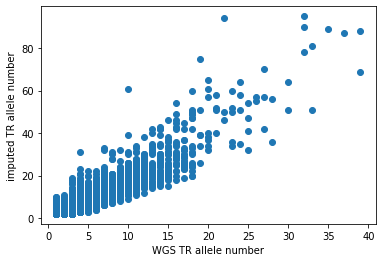

In [118]:
plt.scatter(concord_df_final.wgs_alleles_num, concord_df_final.impute_alleles_num)
plt.xlabel("WGS TR allele number")
plt.ylabel("imputed TR allele number")

### summarize the difference and plot

In [84]:
bins = [i/10 for i in range(0,11)]
all_bin = []
bin_size = []
for i in range(len(bins)-1):
    lower = bins[i]
    upper = bins[i+1]
    curr_bin_size = sum((concord_df_final.concordant_frac > lower) & (concord_df_final.concordant_frac <= upper))
    curr_bin = f"{lower}-{upper}"
    bin_size.append(curr_bin_size)
    all_bin.append(curr_bin)
    
identical_summary = pd.DataFrame({"bin":all_bin,"num":bin_size})
identical_summary["fraction"] = (identical_summary.num/len(concord_df_final)).apply(lambda x: round(x,2))

bins = np.arange(0,20,2)
all_bin = []
bin_size = []
for i in range(len(bins)-1):
    lower = bins[i]
    upper = bins[i+1]
    curr_bin_size = sum((concord_df_final.len_diff_sum > lower) & (concord_df_final.len_diff_sum <= upper))
    curr_bin = f"{lower}-{upper}"
    bin_size.append(curr_bin_size)
    all_bin.append(curr_bin)
lenDiff_summary = pd.DataFrame({"bin":all_bin,"num":bin_size})
lenDiff_summary["fraction"] = (lenDiff_summary.num/len(concord_df_final)).apply(lambda x: round(x,2))


bins = [i/10 for i in range(0,11)]
all_bin = []
bin_size = []
for i in range(len(bins)-1):
    lower = bins[i]
    upper = bins[i+1]
    curr_bin_size = sum((concord_df_final[~concord_df_final.pearson_r.isnull()].pearson_r> lower) & (concord_df_final[~concord_df_final.pearson_r.isnull()].pearson_r <= upper))
    curr_bin = f"{lower}-{upper}"
    bin_size.append(curr_bin_size)
    all_bin.append(curr_bin)
    
pearson_sumary = pd.DataFrame({"bin":all_bin,"num":bin_size})
pearson_sumary["fraction"] = (pearson_sumary.num/len(concord_df_final)).apply(lambda x: round(x,2))

In [90]:
pearson_sumary.loc[[8,9]].sum()

bin         0.8-0.90.9-1.0
num                   8540
fraction              0.78
dtype: object

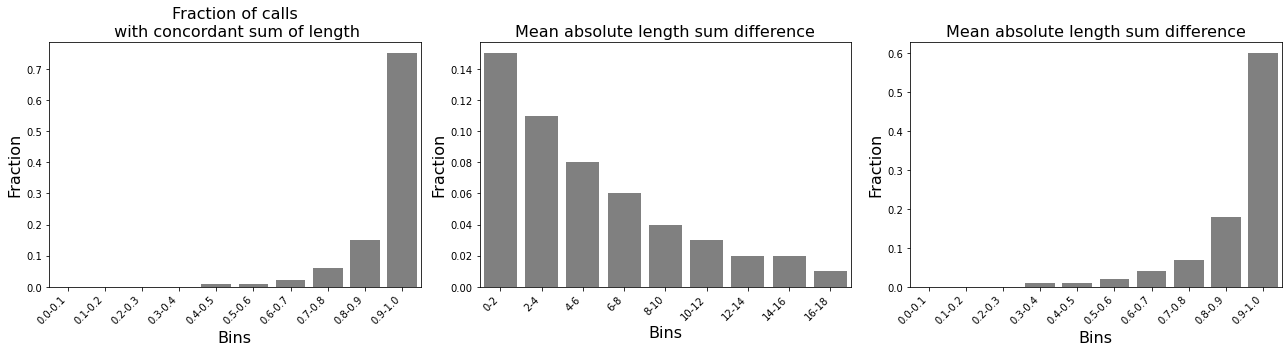

In [87]:
fig, axs = plt.subplots(1,3,figsize=(18,5))
ax_list = axs.flatten()
sns.barplot(x="bin",y="fraction",data=identical_summary, color="grey",ax=ax_list[0])# x = plot_data.wgs_major_fre.tolist()
_=ax_list[0].set_xticklabels(ax_list[0].get_xticklabels(), rotation=45,ha="right")
ax_list[0].set_xlabel("Bins", fontsize=16)
ax_list[0].set_ylabel("Fraction", fontsize=16)
ax_list[0].set_title("Fraction of calls\n with concordant sum of length", fontsize=16)


sns.barplot(x="bin",y="fraction",data=lenDiff_summary, color="grey",ax=ax_list[1])# x = plot_data.wgs_major_fre.tolist()
_=ax_list[1].set_xticklabels(ax_list[1].get_xticklabels(), rotation=45,ha="right")
ax_list[1].set_xlabel("Bins", fontsize=16)
ax_list[1].set_ylabel("Fraction", fontsize=16)
ax_list[1].set_title("Mean absolute length sum difference", fontsize=16)
fig.tight_layout()

sns.barplot(x="bin",y="fraction",data=pearson_sumary, color="grey",ax=ax_list[2])# x = plot_data.wgs_major_fre.tolist()
_=ax_list[2].set_xticklabels(ax_list[2].get_xticklabels(), rotation=45,ha="right")
ax_list[2].set_xlabel("Bins", fontsize=16)
ax_list[2].set_ylabel("Fraction", fontsize=16)
ax_list[2].set_title("Pearson r correclation", fontsize=16)
fig.tight_layout()

## Check why some of loci have huge length difference

In [227]:
def checkExample(pos):
    print("WGS")
    display(wgs_df[wgs_df.START==pos])
    print("Imputed")
    display(impute_df[impute_df.START==pos])
    print("Concordant")
    display(concord_df[concord_df.START==pos])
    print("Concordant Filtered")
    display(concord_df_final[concord_df_final.START==pos])

In [121]:
concord_df_final[concord_df_final.pearson_r.abs()<0.2]

,START,END,sample_n,pearson_r,pearson_p,len_diff_sum,concordant_sample_n,wgs_alleles_num,impute_alleles_num,concordant_frac
270,14701224,14701243,97,-0.02,0.837823,8.0,93,2,3,0.96
424,15020879,15020890,97,0.18,0.071828,4.5,88,3,3,0.91
449,15099198,15099212,97,0.16,0.110849,4.5,88,2,2,0.91
775,15859992,15860007,97,0.07,0.491808,41.5,78,6,9,0.80
883,16081823,16081833,97,0.02,0.836956,2.5,92,2,5,0.95
...,...,...,...,...,...,...,...,...,...,...
15404,45055824,45055839,97,0.07,0.469692,10.0,85,5,8,0.88
15666,45766892,45766915,88,-0.03,0.762895,8.5,82,3,2,0.93
15800,46197885,46197910,97,-0.02,0.837823,8.0,93,3,7,0.96
15834,46252683,46252696,97,0.03,0.781966,4.0,89,2,3,0.92


### An example of TWO TRs with same START and END that beeen filtered

In [225]:
checkExample(14081510)

WGS


,CHROM,POS,REF,ALT,END,START,AB0009,AB0330,AB0528,AB0867,...,RXV0S,RZD0F,THT0S,TIH0I,VBC0Q,VGD0D,VKS0C,VLD0N,VNB0Q,VVJ0M
33,chr21,14081510,TTATTATTATTATTA,"TTATTATTATTATTATTA,TTATTATTATTA,TTATTATTATTATT...",14081524,14081510,3/0,0/1,0/1,0/0,...,0/1,0/0,0/1,0/1,0/2,0/0,1/2,0/0,1/1,0/0
34,chr21,14081510,TTTTATTATTATTATTAGTAGTAGTAGTAGTAGTAGTAGTAGTAGTA,TATTATTATTATTATTAGTAGTAGTAGTAGTAGTAGTAGTAGTAGT...,14081556,14081510,1/8,5/10,1/2,1/1,...,2/5,1/2,1/2,1/2,0/4,1/3,4/10,5/3,2/10,1/3


Imputed


,CHROM,POS,REF,ALT,END,START,AB0009,AB0330,AB0528,AB0867,...,RXV0S,RZD0F,THT0S,TIH0I,VBC0Q,VGD0D,VKS0C,VLD0N,VNB0Q,VVJ0M
14,chr21,14081510,TTATTATTATTATTA,"TTATTATTATTATTATTA,TTATTATTATTATTATTATTA,TTATT...",14081524,14081510,3|0,1|0,1|1,0|0,...,0|1,4|1,0|1,1|0,4|0,0|0,1|0,0|0,1|0,0|0


Concordant


,START,END,sample_n,len_diff_sum,concordant_sample_n,wgs_alleles_num,impute_alleles_num
11,14081510,14081524,97,49.5,76,5,8
12,14081510,14081524,96,3079.5,0,15,8


### An exmpale show the huge difference of length is due to REF

In [242]:
checkExample(44647019.0)

WGS


,CHROM,POS,REF,ALT,END,START,AB0009,AB0330,AB0528,AB0867,...,RXV0S,RZD0F,THT0S,TIH0I,VBC0Q,VGD0D,VKS0C,VLD0N,VNB0Q,VVJ0M
28889,chr21,44647019,CTGCTGCGTGCCTGTCTGCTGCAAGACTGTCTACTGCAAGCCCATC...,"CTGCTGCAAGCCTGTCTGCTGCAAGCCTGT,CTGCTGCAAGCCTGT...",44647146,44647019,0/0,1/0,1/0,0/0,...,0/0,0/0,.,0/3,0/0,0/0,0/0,0/0,2/2,0/0


Imputed


,CHROM,POS,REF,ALT,END,START,AB0009,AB0330,AB0528,AB0867,...,RXV0S,RZD0F,THT0S,TIH0I,VBC0Q,VGD0D,VKS0C,VLD0N,VNB0Q,VVJ0M
12211,chr21,44647019,CTGCTGCGTGCCTGTCTGCTGCAAGACTGTCTACTGCAAGCCCATC...,"CTGCTGCAAGCCTGTCTGCTGCAAGCCTGT,CTGCTGCAAGCCTGT...",44647146,44647019,0|0,0|0,0|0,0|0,...,0|0,0|1,0|0,0|0,2|0,0|0,1|0,0|0,0|1,2|0


Concordant


,START,END,sample_n,len_diff_sum,concordant_sample_n,wgs_alleles_num,impute_alleles_num
15238,44647019,44647146,84,1869.0,31,5,9


Concordant Filtered


,START,END,sample_n,len_diff_sum,concordant_sample_n,wgs_alleles_num,impute_alleles_num
15238,44647019,44647146,84,1869.0,31,5,9


In [241]:
display(getAlleleLen(wgs_df.loc[28889]))
display(getAlleleLen(impute_df.loc[12211]))

{0: 128, 1: 30, 2: 75, 3: 105, 4: 60}

{0: 128, 1: 30, 2: 75, 3: 105, 4: 90, 5: 45, 6: 135, 7: 60, 8: 15}